# Rent in the City: Analysing Rental Data in the Birmingham Area 

## Introduction

It's common knowledge that renting property in the city is more expensive than elsewhere. Higher demand for property, less available space, and improved access to businesses and locations all drive prices up. However, once you're in the city, do these variables continue to have a positive correlation with rental price? 

What I will analyse in our data is the effect of **proximity to the city centre** and the **number of bedrooms** on the rental price of properties in the central Birmingham area.

We will be scraping data from the property website **[OnTheMarket](https://www.onthemarket.com)** for this portfolio piece.

## Questions

Based on the data we are collecting, we will seek to answer: 

1. What is the distribution of rental property prices in Birmingham?
2. Does distance to city centre affect rental price?
3. Does the number of bedrooms affect rental price? 

## Data Environment

First, we will import and install the necessary libraries for our project.

In [1]:
from bs4 import BeautifulSoup
import lxml
import json
import requests
import regex as re
import pandas as pd
!pip install pgeocode
import pgeocode
!pip install --upgrade seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Scraping

We use the BeautifulSoup and Requests libraries to request data from our source. Headers are specified to ensure the website accepts the request. We then use lxml to parse it, regex to find patterns within the data, and the json library to parse the json objects within the data to allow us to access the necessary data. 

As the number of pages of property data changes regularly, we have chosen to search the first 50 pages of URLs as this will make the code consistently scrape all available data. This data is applied to three lists that will make up our pandas dataframe's columns.

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Referer": "https://www.onthemarket.com/",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive"
}

bedroom_counts = []
clean_addresses = []
all_prices = []
pagenum = 1

for pagenumber in range(50):
    url = f'https://www.onthemarket.com/to-rent/property/birmingham/?page={pagenum}'
    print(url)
    pagenum += 1

    response = requests.get(url,headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser')

    #Addresses
    addresses = soup.find_all('span',class_="address")
    #clean_addresses = []
    for item in addresses:
        clean_text = item.get_text(strip=True)
        clean_addresses.append(clean_text)
    #Prices
    price_pattern = re.search(r'"property-prices":\[(.*?)\]', response.text)
    
    if price_pattern:
        price_list = price_pattern.group(1)  # Extract content inside brackets
        prices = json.loads(f"[{price_list}]")  # Convert string to list
        all_prices.extend(prices)
    
    #Bedrooms
    bedroom_tags = soup.find_all("div", itemprop="numberOfBedrooms")
    
    for idx, tag in enumerate(bedroom_tags, start=1):
        bedrooms = tag.get_text(strip=True)
        if bedrooms.lower() == 'studio':
            bedrooms = '1'
        elif bedrooms == '-':
            bedrooms = '1'
        bedroom_counts.append(bedrooms)  

https://www.onthemarket.com/to-rent/property/birmingham/?page=1
https://www.onthemarket.com/to-rent/property/birmingham/?page=2
https://www.onthemarket.com/to-rent/property/birmingham/?page=3
https://www.onthemarket.com/to-rent/property/birmingham/?page=4
https://www.onthemarket.com/to-rent/property/birmingham/?page=5
https://www.onthemarket.com/to-rent/property/birmingham/?page=6
https://www.onthemarket.com/to-rent/property/birmingham/?page=7
https://www.onthemarket.com/to-rent/property/birmingham/?page=8
https://www.onthemarket.com/to-rent/property/birmingham/?page=9
https://www.onthemarket.com/to-rent/property/birmingham/?page=10
https://www.onthemarket.com/to-rent/property/birmingham/?page=11
https://www.onthemarket.com/to-rent/property/birmingham/?page=12
https://www.onthemarket.com/to-rent/property/birmingham/?page=13
https://www.onthemarket.com/to-rent/property/birmingham/?page=14
https://www.onthemarket.com/to-rent/property/birmingham/?page=15
https://www.onthemarket.com/to-ren

## Create DataFrame and save to .csv

At this stage, we create our DataFrame in Pandas, save it to a .csv for easy access later, and view the top 5 values to ensure data is correctly scraped.

In [3]:
df = pd.DataFrame({'Address':clean_addresses,
                   'Rent (£pcm)':all_prices,
                   'Bedrooms':bedroom_counts})

df.to_csv('RentalData.csv')

df.head(5)

,Address,Rent (£pcm),Bedrooms
0,"Wellman Croft, Birmingham","1,400",3
1,"6 Legge Lane, B1 3LG","1,350",2
2,"West Boulevard, Birmingham B32","1,200",3
3,"Metchley Lane, Harborne, B17","1,750",3
4,"at Soho Wharf, Apartment 1304, 61 Hooper Stree...",990,1


## Work out distance to City Centre

Utilising Regex to match any appropriate patterns, here we extract the Postcode from each property that has one in the listing title. Using this in combination with the pgeocode library, we can calculate the distance between the property and the City Centre. For properties without a postcode, we drop them from the database.

In [4]:
def extract_postcode(address):
    match = re.search(r'B\d\d', address)
    return match.group() if match else 'N/A'

postcodes = []
for address in clean_addresses:
    postcodes.append(extract_postcode(address))

dist = pgeocode.GeoDistance('GB')
distance = []
for item in postcodes:
    if item == 'N/A':
        distance.append('No Postcode')
    else:
        distance.append(dist.query_postal_code(item,'B1').round(2))

df['Distance to City Centre (km)'] = distance
df = df[df['Distance to City Centre (km)'] != 'No Postcode']

## Clean the DataFrame

Lastly, we prepare the DataFrame for analysis. Data is converted to numeric data, and unnecessary columns are dropped.

In [5]:
df['Rent (£pcm)'] = df['Rent (£pcm)'].astype(str).str.replace('£', '', regex=False).str.replace(',', '').str.strip()
df['Rent (£pcm)'] = pd.to_numeric(df['Rent (£pcm)'], errors='coerce')
df['Rent (£pcm)'] = df['Rent (£pcm)'].astype(float)

df['Distance to City Centre (km)'] = df['Distance to City Centre (km)'].astype(str).str.strip()
df['Distance to City Centre (km)'] = pd.to_numeric(df['Distance to City Centre (km)'],errors ='coerce').round(2)

df['Bedrooms'] = pd.to_numeric(df['Bedrooms'])

df = df.drop(['Address'], axis = 1)
df = df.dropna()
df = df.reset_index()
df

,index,Rent (£pcm),Bedrooms,Distance to City Centre (km)
0,2,1200,3,8.55
1,3,1750,3,4.65
2,4,990,1,0.00
3,5,1748,3,0.00
4,6,1283,2,0.00
...,...,...,...,...
724,1008,1200,2,2.57
725,1009,1200,3,8.55
726,1011,1050,2,2.57
727,1012,1600,2,2.38


## Analyse Data 

Now that data has been cleaned and prepared, we will plot graphs in order to answer the questions highlighted at the beginning of this project.

## 1. What is the distribution of rental property prices in Birmingham?

We display this in a straightforward histogram. The results indicate that the majority of listings fit in the £500 - £2000 price range, peaking at £1200. There are few listings for 'luxury' properties exceeding this range.

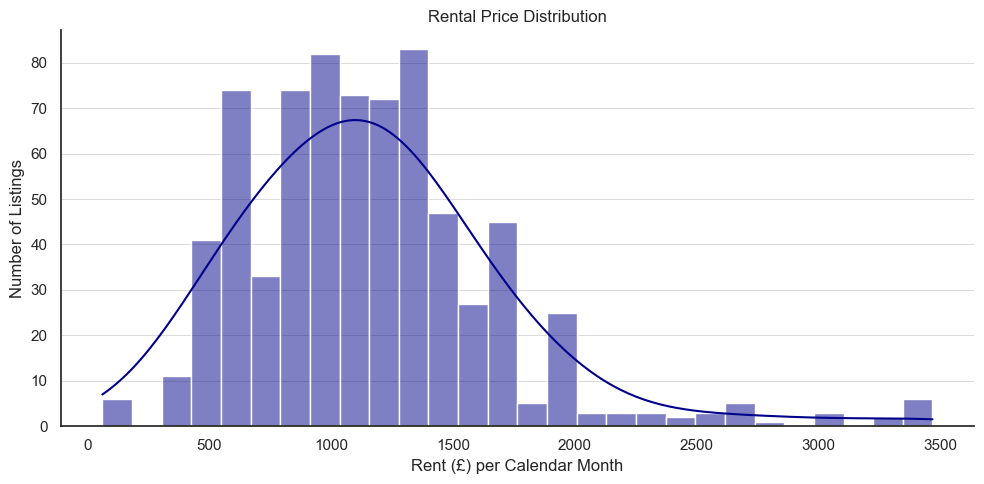

In [6]:
sns.set_theme(style="white")
plt.figure(figsize=(10,5))

ax = sns.histplot(df['Rent (£pcm)'],color='darkblue',alpha=0.5,kde=True, kde_kws={'bw_adjust': 2})

plt.title('Rental Price Distribution')
plt.xlabel('Rent (£) per Calendar Month')
plt.ylabel('Number of Listings')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=1)
sns.despine()

plt.savefig('RentalPriceDistribution.jpg')
plt.show()

## 2. Does distance to city centre affect rental price?

We explored this question using two graphs: A violin plot to explore the distribution of rental prices within groups of distance from the City Centre, and in a scatterplot, where we can examine if there is any overall trends. To create the violin plot we needed to create some custom bins to encompass certain distance ranges - We used ranges of 2 km as this gave us plenty of data in each bin to work with.

## Violin Plot

Our violin plot found that rental price was largely unaffected by distance from the city centre. Whilst we expected to find the most expensive properties directly in the city centre, this was not the case. Overall it seems that the greatest variety in rental price is in the 4-6 km distance range, but all distances showed a variety of prices. This would indicate that other variables are more impactful than distance to the city centre.

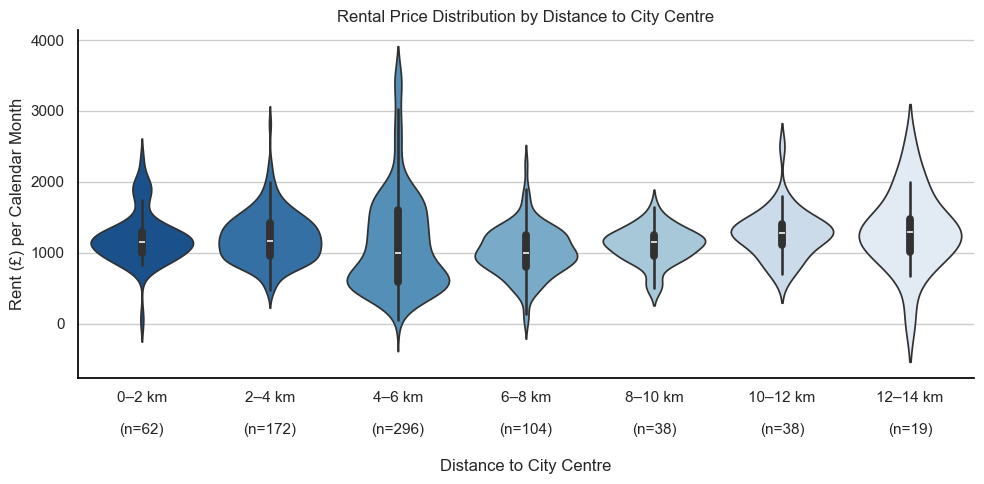

In [7]:
bins = [-0.1, 2, 4, 6, 8, 10, 12, 14]
labels = ['0–2 km', '2–4 km', '4–6 km', '6–8 km', '8–10 km', '10–12 km', '12–14 km']

df['Distance Bin'] = pd.cut(df['Distance to City Centre (km)'], bins=bins, labels=labels)

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

ax = sns.violinplot(x='Distance Bin', y='Rent (£pcm)', data=df, density_norm='width', hue='Distance Bin',palette='Blues_r')

plt.title('Rental Price Distribution by Distance to City Centre')
plt.xlabel('Distance to City Centre')
plt.ylabel('Rent (£) per Calendar Month')
counts = df['Distance Bin'].value_counts().reindex(labels)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels([f"{label}\n\n(n={counts[label]})\n" for label in labels])

plt.tight_layout()
sns.despine()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('RentToDistanceViolinPlot.jpg')
plt.show()

## Scatter plot

The findings from the scatter plot are in keeping with our violin plot, in that it shows no correlation between our variables as indicated by the regression line. Overall, we can see that there is a lot of variation in rental price regardless of the distance to the city centre.

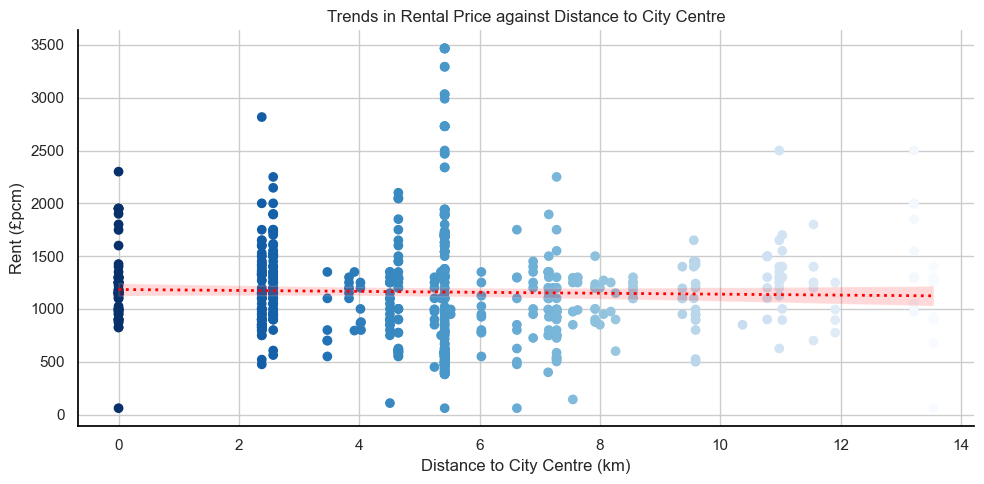

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")

scatter = plt.scatter(x=df['Distance to City Centre (km)'], y=df['Rent (£pcm)'], c=df['Distance to City Centre (km)'], cmap='Blues_r')

plt.title('Trends in Rental Price against Distance to City Centre')
plt.xlabel('Distance to City Centre')
plt.ylabel('Rent (£) per Calendar Month')
ax = sns.regplot( x=df['Distance to City Centre (km)'], y=df['Rent (£pcm)'],scatter=False,line_kws={'color': 'red', 'linewidth': 2,'linestyle':'dotted'})

plt.tight_layout()
sns.despine()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('RentToDistanceScatterPlot.jpg')
plt.show()

## 3. Does the number of bedrooms affect rental price?

We explore this final question with a box plot and a bar chart. For the box plot, we grouped the number of bedrooms variable into a single bin to create a more readable graph.

## Box Plot

This plot shows that there is a positive correlation between our variables - There is a steady increase in both the median and interquartile range of rental prices as the number of bedrooms increases. The 5+ bedroom plot has a significantly larger range, likely due to there being a mixture of large, luxury homes and sharehouses. 

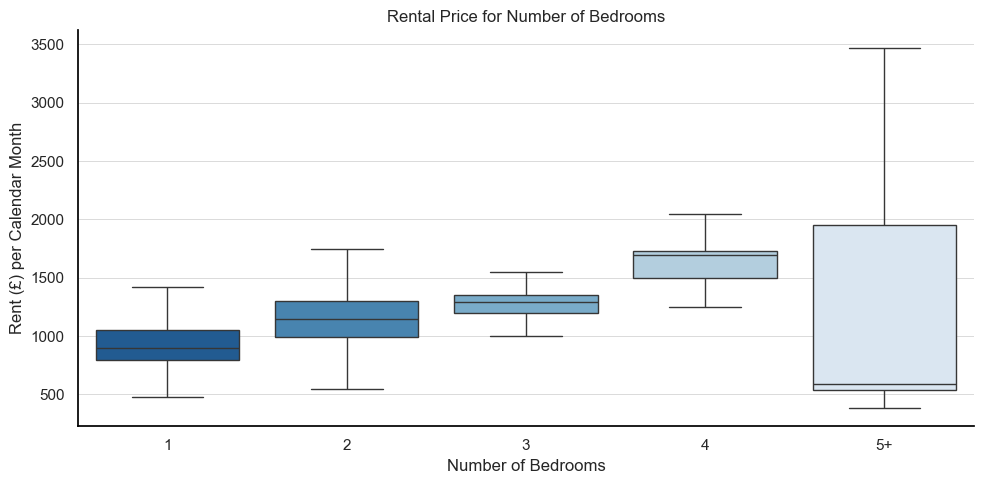

In [9]:
df['Bedrooms Grouped'] = df['Bedrooms'].apply(lambda x: str(x) if x <= 4 else '5+')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))

df = df.sort_values(by="Bedrooms", ascending=True)

ax = sns.boxplot(x=df['Bedrooms Grouped'],y=df['Rent (£pcm)'],showfliers=False,hue=df['Bedrooms Grouped'],palette='Blues_r')

plt.title('Rental Price for Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Rent (£) per Calendar Month')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=1)
sns.despine()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('BedroomsToRentBoxPlot.jpg')
plt.show()


## Bar Chart

This chart presents the same data as the box plot above - As bedrooms increases (below 5 bedrooms), so does rental price. We also see a confirmation of the large range of prices in larger properties.

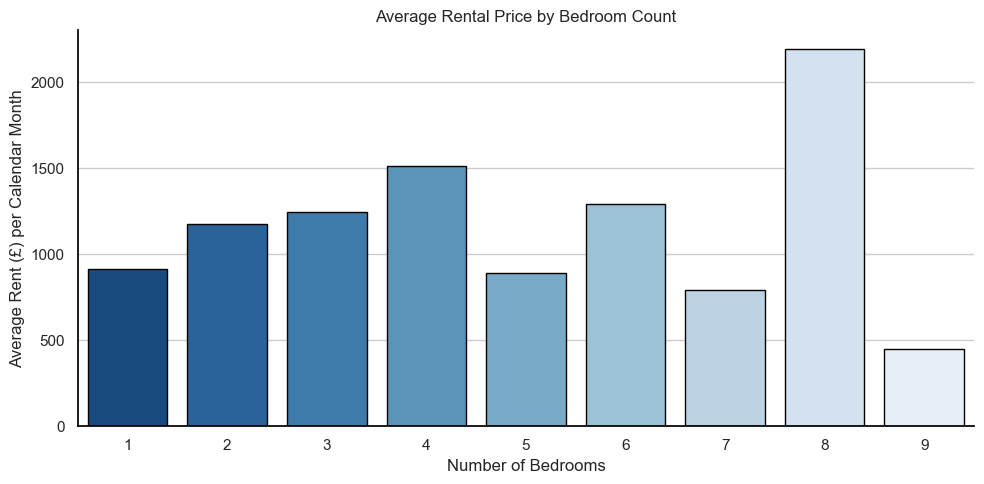

In [18]:
avg_rent = df.groupby('Bedrooms')['Rent (£pcm)'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

colors = sns.color_palette("Blues_r", n_colors=len(avg_rent))
ax = sns.barplot( x='Bedrooms', y='Rent (£pcm)', data=avg_rent, palette=colors,hue='Bedrooms',legend=False)

plt.title('Average Rental Price by Bedroom Count')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Rent (£) per Calendar Month')

for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

plt.tight_layout()
sns.despine()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.savefig('BedroomsToAverageRentBarChart.jpg')
plt.show()


# Overall Findings

Our research indicates that there is no observable correlation between rental price and distance from the city centre. However, we did find a positive correlation between the number of bedrooms and rental price.

# Limitations of the Project

1. Dataset Size - Many of the properties in our original dataset did not have a postcode and were dropped from our dataframe. A larger dataset would provide us with more robust conclusions.
   
2. Geographical Scope - We researched areas within 14 km of Birmingham city centre. Having a larger area of research could have provided more insight into our research topic.
   
3. Data Anomalies - The properties in our dataset were not examined individually. There could potentially be errors or anomalies within the dataset, such as multiple listings for the same property, or buildings that weren't properties being included. 

# Further Research

Further research should consider implementing the project on a wider geographical scale, including areas on the outskirts of the city so that we can analyse if there is a certain cutoff point from which rental price is affected by distance to the city centre. Implementing research with more sources would also be effective, especially in regards to properties with either 5+ bedrooms or a 10+ km distance from the city centre, as the quantity of data for these properties was comparitively low when compared against the more central properties. 